In [1]:
import os
import sys
import cv2
import time
import torch
import random
import pathlib
import logging
import albumentations
from functools import partial

import numpy as np
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from mmcv.runner import build_optimizer
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from torchviz import make_dot

from models.segformer import Segformer
# from segformer_pytorch import Segformer
from models.segformer_utils.mix_transformer import mit_b5, mit_b0

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)

plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
%config InlineBackend.figure_format = 'retina'

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
transforms_training = ComposeDouble([
    FunctionWrapperDouble(random_resize, scale_factor=16, base_size=cfg.DATASET.BASE_SIZE[1], both=True),
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(random_brightness, input=True, target=False),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, 
                          input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])


transforms_validation = ComposeDouble([
    FunctionWrapperDouble(random_crop, crop_size=cfg.DATASET.CROP_SIZE, 
                          ignore_label=cfg.DATASET.IGNORE_LABEL, both=True),
    FunctionWrapperDouble(label_mapping, label_map=id2label, input=False, target=True),
    FunctionWrapperDouble(normalize, mean=cfg.DATASET.MEAN, std=cfg.DATASET.STD, 
                          input=True, target=False),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
])

In [3]:
train_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "train", transform = transforms_training)
valid_dataset = SegmentationDataset(cfg = cfg.DATASET, split = "val", transform = transforms_validation)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = cfg.TRAIN.BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = cfg.TRAIN.BATCH_SIZE, shuffle = True)

x, y, _, names = next(iter(train_dataloader))
xv, yv, _, vnames = next(iter(valid_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

x.shape: (8, 3, 1024, 1024), x.type: torch.float32, [min(x), max(x)]: [-2.118, 2.640]
y.shape: (8, 1024, 1024), y.type: torch.int64 
y unique: [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 255]


In [4]:
def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=150)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

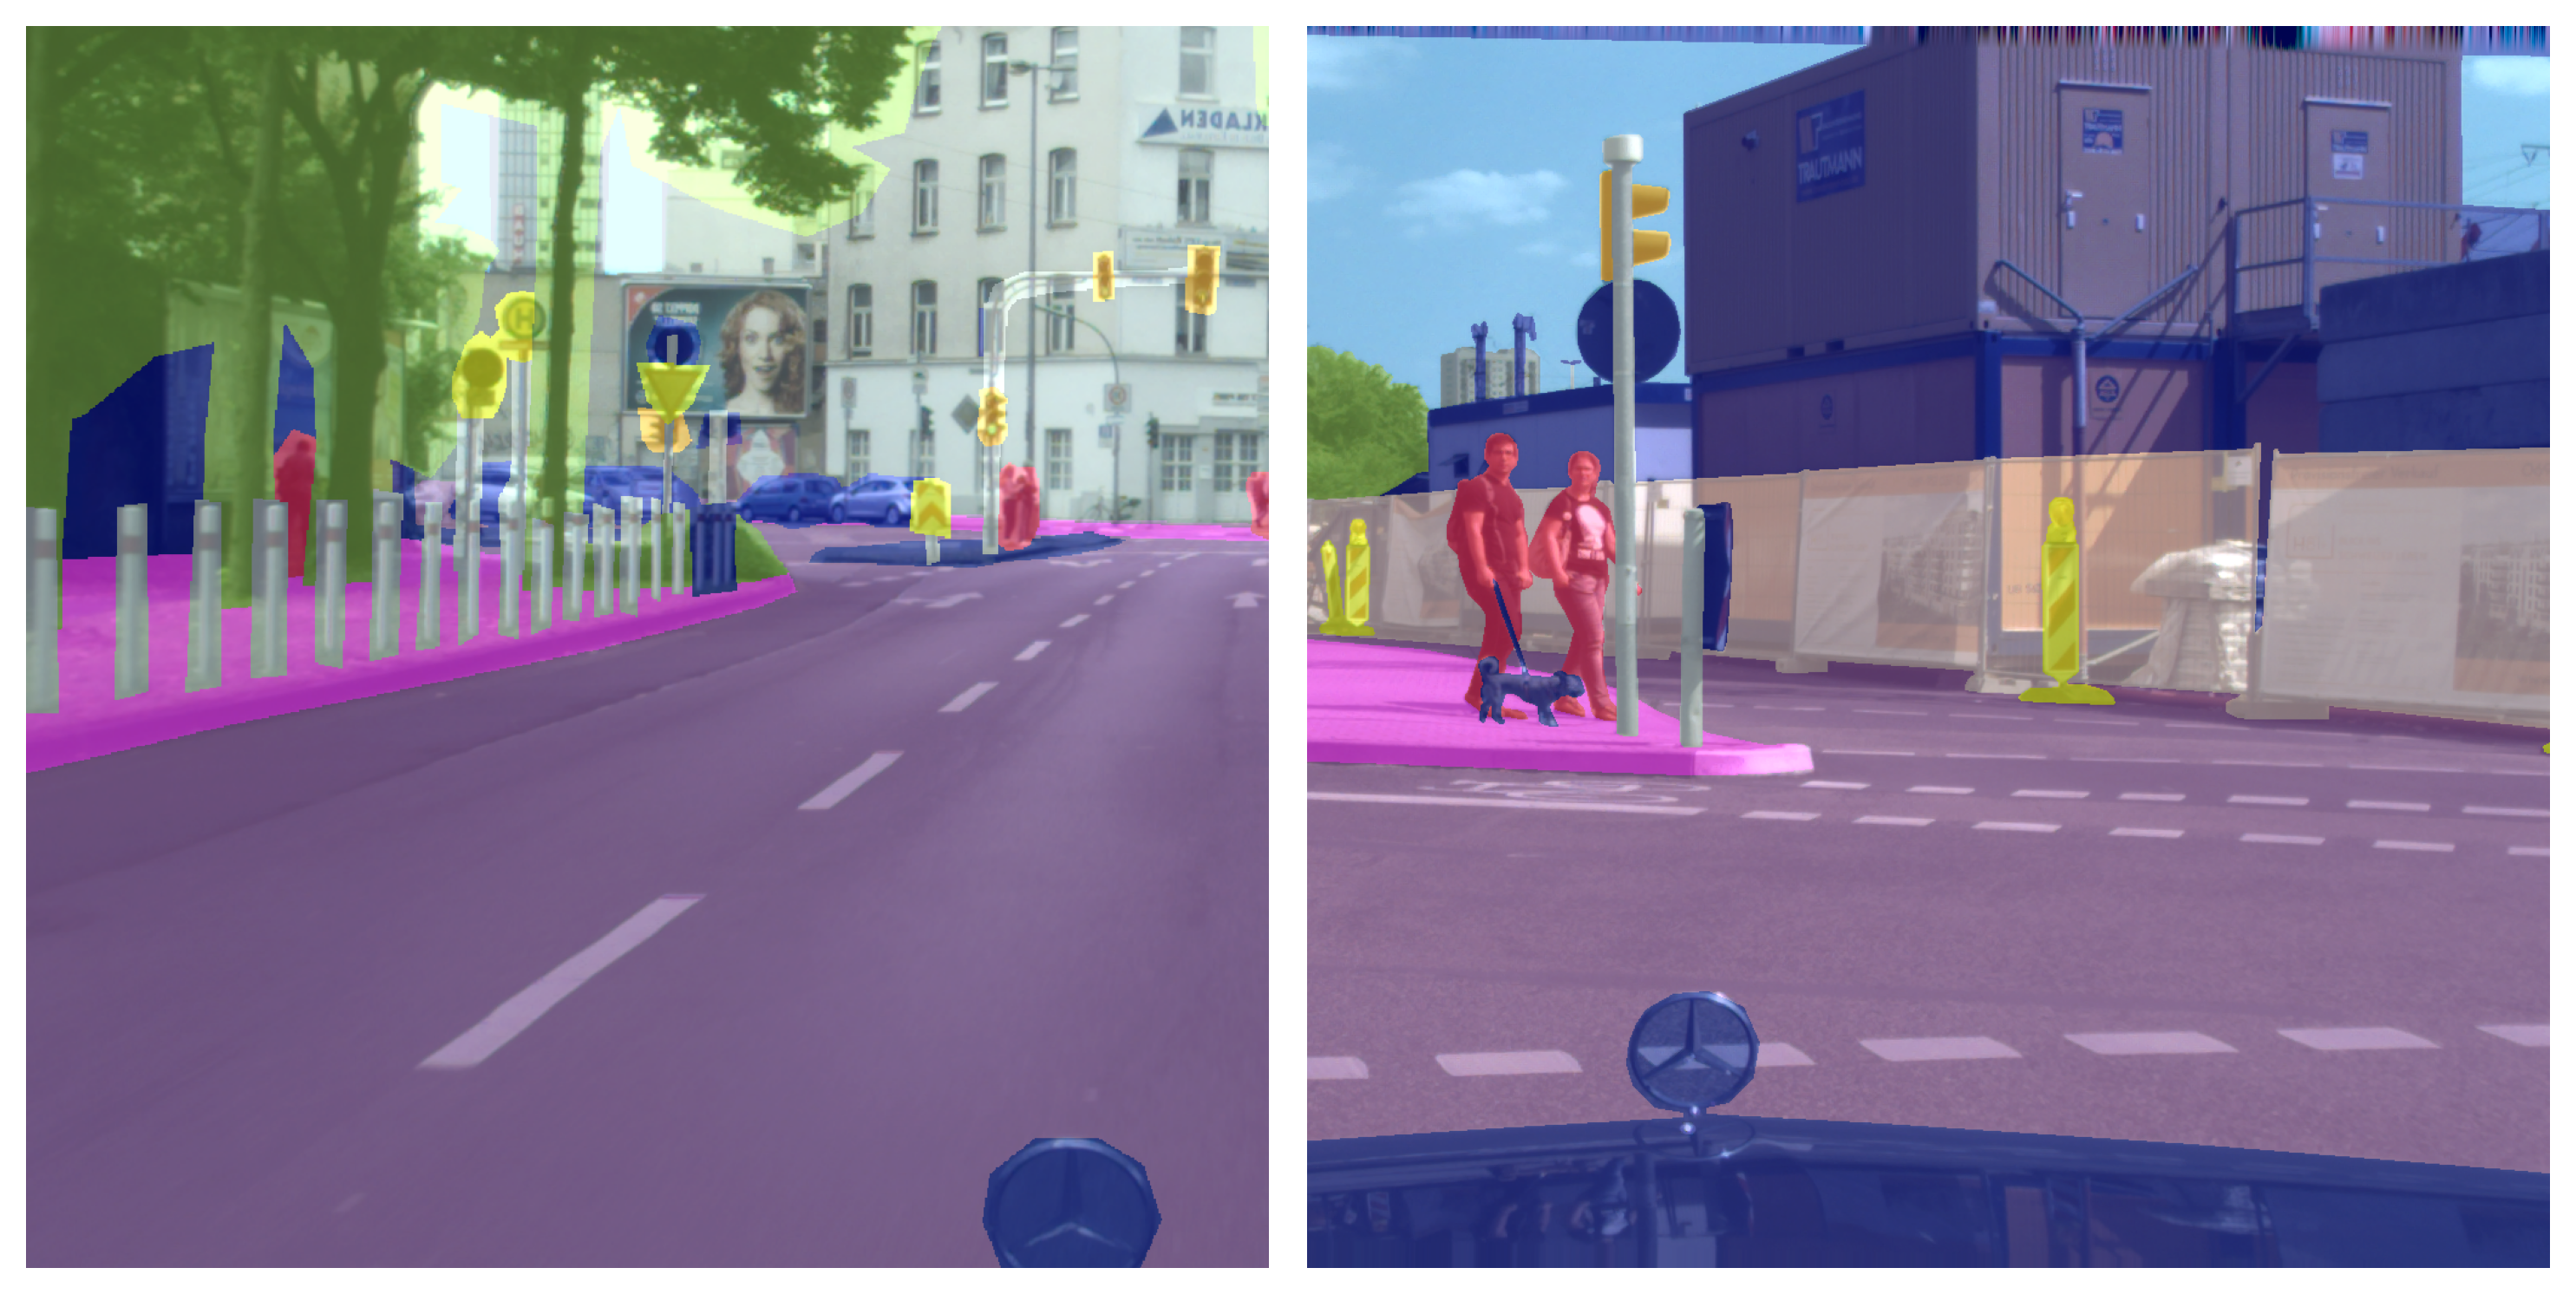

In [5]:
idx = 0
display_blend([
    [re_normalize(x[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(y[idx])],
    [re_normalize(xv[idx].permute(1,2,0).numpy()), cityscapes_label_to_rgb(yv[idx])]
])

In [6]:
# model = Segformer(
#     encoder = mit_b5(),
#     dims = cfg.MODEL.CHANNEL_DIMS,                    
#     decoder_dim = cfg.MODEL.DECODER_DIM,                                
#     feature_strides = cfg.MODEL.FEATURE_STRIDES,
#     num_classes = cfg.DATASET.NUM_CLASSES,               
#     pretrained=cfg.MODEL.PRETRAINED
# ).to(device)

# model = Segformer(
#     dims = (64, 128, 320, 512),      # dimensions of each stage
#     heads = (1, 2, 5, 8),           # heads of each stage
#     ff_expansion = (4, 4, 4, 4),    # feedforward expansion factor of each stage
#     reduction_ratio = (8, 4, 2, 1), # reduction ratio of each stage for efficient attention
#     num_layers = (3, 6, 40, 3),     # num layers of each stage
#     decoder_dim = 768,              # decoder dimension
#     num_classes = 19                # number of segmentation classes
# ).to(device)

model = Segformer(
    pretrained=cfg.MODEL.PRETRAINED,
    img_size=1024,
    patch_size=4, 
    embed_dims=[64, 128, 320, 512], 
    num_heads=[1, 2, 5, 8], 
    mlp_ratios=[4, 4, 4, 4],
    qkv_bias=True, 
    norm_layer=partial(nn.LayerNorm, eps=1e-6), 
    depths=[3, 6, 40, 3], 
    sr_ratios=[8, 4, 2, 1],
    drop_rate=0.0, 
    drop_path_rate=0.1,
    decoder_dim = 768
)



criterion = CrossEntropy(
    ignore_label=cfg.DATASET.IGNORE_LABEL, 
    weight=train_dataset.class_weights
).to(device)


optimizer_cfg = dict(
    type=cfg.TRAIN.OPTIMIZER, 
    lr=cfg.TRAIN.BASE_LR,  
    weight_decay=cfg.TRAIN.WD,
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.), 
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
))

optimizer = build_optimizer(model, optimizer_cfg)

lr_scheduler = PolyLrUpdater(
    optimizer = optimizer,
    power = cfg.TRAIN.POWER,
    min_lr = cfg.TRAIN.MIN_LR,
    max_iters = cfg.TRAIN.DECAY_STEPS,
    epoch_len = len(train_dataloader),
    warmup = cfg.TRAIN.WARMUP,
    warmup_iters = cfg.TRAIN.WARMUP_ITERS,
    warmup_ratio = cfg.TRAIN.WARMUP_RATIO,
    by_epoch = cfg.TRAIN.BY_EPOCH,
)

2021-08-28 05:22:15,920 - mmseg - INFO - Use load_from_local loader
2021-08-28 05:22:16,349 - mmseg - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.weight, head.bias

missing keys in source state_dict: linear_c4.proj.weight, linear_c4.proj.bias, linear_c3.proj.weight, linear_c3.proj.bias, linear_c2.proj.weight, linear_c2.proj.bias, linear_c1.proj.weight, linear_c1.proj.bias, linear_fuse.weight, linear_fuse.bias, linear_pred.weight, linear_pred.bias



In [7]:
# lr_arr = []

# lr_scheduler.before_run()
# for step in range(0, 160000):
#     lr_scheduler.before_train_iter()
#     lr = lr_scheduler.get_lr(step, cfg.TRAIN.BASE_LR)
#     lr_arr.append(optimizer.param_groups[0]['lr'])
#     if step % 1000 == 0:
#         print("\r step: {} --- lr = {}".format(step, optimizer.param_groups[0]['lr']), end='')
        
# plt.figure(figsize=(15,5))
# plt.plot(np.arange(0,160000), lr_arr)
# plt.yscale("log")
# plt.ylabel("LR", fontsize=18)
# plt.xlabel("Step", fontsize=18)
# plt.show()

In [8]:
model.eval()
x = torch.rand((1, 3, cfg.DATASET.CROP_SIZE[0], cfg.DATASET.CROP_SIZE[1]))
y = model(x)
print(y.size())

torch.Size([1, 19, 1024, 1024])


In [9]:
# make_dot(
#     y.mean(), 
#     params=dict(
#     model.named_parameters()), 
#     show_attrs=False, 
#     show_saved=False,
#     max_attr_chars=50
# ).render("segformer_simple_b0_graph", format="png")

In [10]:
details = get_model_summary(model, x, verbose=False)
print(details)


Total Parameters: 85,915,731
----------------------------------------------------------------------------------------------------
Total Multiply Adds (For Convolution and Linear Layers only): 11,607.056640625 GFLOPs
----------------------------------------------------------------------------------------------------
Number of Layers
Conv2d : 107 layers   LayerNorm : 161 layers   OverlapPatchEmbed : 4 layers   Linear : 264 layers   Dropout : 208 layers   Attention : 52 layers   Identity : 2 layers   DWConv : 52 layers   GELU : 52 layers   Mlp : 52 layers   Block : 52 layers   DropPath : 102 layers   LinearMLP : 4 layers   Dropout2d : 1 layers   


In [ ]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(
        config, 
        cfg_name=cfg.NAME, 
        phase='train'
    )
    
    writer_dict = {
        'writer': SummaryWriter(tb_log_dir),
        'train_global_steps': 0,
        'valid_global_steps': 0,
    }

    best_mIoU = 0

    start = timeit.default_timer()
    for epoch in range(cfg.TRAIN.EPOCHS):

        train(
            cfg=cfg, 
            dataloader=train_dataloader, 
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth'))

        msg = 'Epoch {}/{} --- Loss: {:.3f}, MeanIU: {: 4.4f}, Best_mIoU: {: 4.4f} \n'.format(
            epoch+1, cfg.TRAIN.EPOCHS, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
run_train_loop()

In [ ]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(config, eval_dataloader, model, 
                                                   sv_dir=cfg.OUTPUT_DIR, sv_pred=True)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))